In [1]:
from module.prepare import *
from itertools import product
from sklearn.externals import joblib
from sklearn import metrics
# import pygraphviz

def scoreFunction(cv_results):
    scores = {
        'acc':[],
        'auc':[],
    }

    for result in cv_results:
        acc = metrics.accuracy_score(result[0],result[1])
        auc = metrics.roc_auc_score(result[0],result[1])
        scores['acc'].append(acc)
        scores['auc'].append(auc)
    
    return scores

D:\anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


#### LGB

In [10]:
def LGBTuning(Xtrain,Xtest,Ytrain,Ytest,tuning=True):
    
    clf = lgb.LGBMClassifier(objective='cross_entropy', ### {cross_entropy, binary}
                             silent=False,
                             verbose=1,
                             random_state=seed,
                             n_jobs=7,
#                              class_weight
                            )
    
    gridParams = {
        # step 1
#     'learning_rate': [0.01,0.05,0.1],
#     'boosting_type':['gbdt','goss'],
#     'n_estimators': [50,200,500],
#     'num_iterations':[200,400,1000],
        # step 1 fixed
    'learning_rate': [0.1], ### 0.1
    'boosting_type':['gbdt'], ### goss>gbdt
    'n_estimators': [500],
    'num_iterations':[2000], ### 2000
#     'max_depth':[6], ### <6
        # step 2
    'num_leaves': [200], ### <400<675
#     'min_data_in_leaf':[18,20,22], ### 20 default
#     'max_bin':[127,255,511],
        # step 2 fixed
#     'num_leaves': [800],
    'max_bin':[256],
        # step 3
#     'max_depth':[7,8,9,10], ### missed
    'colsample_bytree' : [0.75], ### 0.75
    'subsample_freq':[1], ### 1
    'subsample' : np.linspace(0.7,0.9,5), ### 1
    'min_data_in_leaf':[int(x) for x in np.linspace(22,30,5)],
#     'early_stopping_round':[2],
#     'reg_alpha' : [1e-3], ### 0
#     'reg_lambda' : [0,0.1,0.5], ### 0
    }

    if tuning:
        grid = GridSearchCV(clf, gridParams,
                        scoring='accuracy',
                        verbose=3,
                        cv=5,
                        n_jobs=1)
        print('default params\n',clf.get_params())
        grid.fit(Xtrain,Ytrain)
        return grid
    else:
        arg_str = ''
        for k,v in gridParams.items():
            if type(v[0])==str:
                arg_str += k+'='+"'"+v[0]+"',"
            else:
                arg_str += k+'='+str(v[0])+","
        eval(
            'clf.'+clf.set_params.__name__+"("
                +arg_str.rstrip(',')+
                ")"
            )
#         clf.class_weight = {1:sum(Ytrain==1),0:sum(Ytrain==0)}
        print('default params\n',clf.get_params())
        clf.fit(Xtrain,Ytrain)
        Ypred = clf.predict(Xtest)
        score_train = clf.score(Xtrain,Ytrain)
        print('train score %f'%score_train)
        return [Ypred,Ytest,score_train,clf]

In [ ]:
def LGBFit(X_train,X_test,Y_train,Y_test):
    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)

    params = {    
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'roc-auc',
#                 'nthread':6,
                'learning_rate':0.08,
                'num_leaves':300, 
                'max_depth': -1,   
                'subsample': 0.9, 
                'colsample_bytree': 0.9, 
#                 'feature_fraction': 1,
#                 'bagging_freq': 8,
# #                 'num_iterations':300,
#                 'min_data_in_leaf':2,
#                 'bagging_fraction': 0.8,
#                 'num_boost_round':3000,
            }

    cv_results = lgb.cv(params, lgb_train, nfold=5  
                        ,stratified=False, shuffle=True
                        ,seed=seed,
                        metrics=['auc','binary_logloss','mae']
                        ,verbose_eval=1)
    print('best n_estimators:', len(cv_results['auc-mean']))
    for k,v in cv_results.items():
        print('best cv score:', k, pd.Series(cv_results[k]).max())
    return [lgb,cv_results]

#### main

In [3]:
hyper_params = GetConfigure()
num_hyper_params = len(hyper_params)
lassocv_param = {'threshold':0.05}

cv = 5
generalize_ratio = 1.0/cv
test_ratio = 1.0/cv
mi_use = False

tuning_mode = True
if tuning_mode:
    cv = 1

cv_results = []
'''
    topK =3000
'''

'\n    topK =3000\n'

In [ ]:
[data,T] = ReadData()

# for i in 
for batch in range(cv):
    INFO('cross validation batch %d'%batch)
    if mi_use==True:
        arr = ToMatrix(data,'sparse')
        [X_train,X_test,Y_train,Y_test] = MutualInformationFeatureSelection2(arr,data,generalize_ratio)
        [X_train,X_test,Y_train,Y_test] = \
            RandomForestDimensionalityReduction(X_train,X_test,Y_train,Y_test)
    else:
        [X,Y] = ToMatrix(data,'dense')
        [X_train,X_test,Y_train,Y_test] = SplitDataset(X,Y,generalize_ratio)
#         X_train,X_test,Y_train,Y_test = IsomapDimensionalityReduction(X_train,X_test,Y_train,Y_test)
#         [X_train,X_test,Y_train,Y_test] = LassoCVFeatureSelection(X_train,X_test,Y_train,Y_test,lassocv_param)
        [X_train,X_test,Y_train,Y_test] = \
            RandomForestDimensionalityReduction(X_train,X_test,Y_train,Y_test)
#         [X_train,X_test,Y_train,Y_test] = \
#             PCADimensionalityReduction(X_train,X_test,Y_train,Y_test)
    if tuning_mode:
        [Xtrain,Ytrain] = merge_train_test(X_train,X_test,Y_train,Y_test)
        grid = LGBTuning(Xtrain,[],Ytrain,[],True)
        cv_results.append(grid)
        break
    else:
        tune_results = LGBTuning(X_train,X_test,Y_train,Y_test,False)
        cv_results.append(tune_results)
        scores = scoreFunction(cv_results)
#     break

scores  

=============RETRIEVE TRIAN DATA=================
# DEBUG: # DEBUG: **************new dl 0***************
# DEBUG: READ SEQ FROM FILE
# DEBUG: READ CLUSTER FROM FILE
regex error 
regex error 
# DEBUG: READ PAIR FROM FILE
read line error 
# DEBUG: GENERATE NEGATIVE PAIR
# DEBUG: negative pair number 10412
INFO::count of negative pairs10412
# DEBUG: PAIR UNION
# DEBUG: EXTRACT FEATURES--PROTEIN
# DEBUG: EXTRACT FEATURES--RNA
# DEBUG: K-MER CALCULATION
# DEBUG: FEATURE UNION
# DEBUG: GARBAGE COLLECTION
MATRIX TRANSFORMATION
INFO::cross validation batch 0
data shape 20824 8984
rf raw data fit score 1.000000
select top K features importances 0.9715596405349152
dimension remained 3500
default params
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': 7, 'num_leaves': 31, 'objective': 'cross_entropy',

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


#### test

In [ ]:
# DecisionTreePrefit(X_train,X_test,Y_train,Y_test)
# [lgb,cv_results] = LGBFit(X_train,X_test,Y_train,Y_test)
# WriteResult(DATASET,cv_results,conf,commons)
np.mean(scores['acc'][-10:])

#### tuning

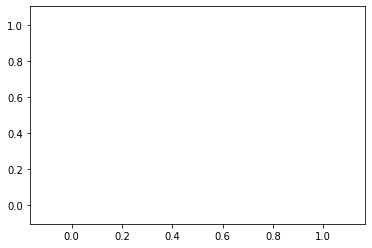

In [5]:
scores = [score for grid in cv_results for score in grid.cv_results_['mean_test_score']]
sns.distplot(scores,rug=True,bins=20)
plt.show()
# param_rank = np.array([grid.cv_results_['mean_test_score'],grid.cv_results_['params']]).T
# a = sorted(param_rank,key=lambda x:x[0],reverse=True)
# a = np.array(list(a))

# a
# max( cv_results,key=lambda x:np.mean(x.cv_results_['mean_test_score']) ).best_params_

array([1., 3.])